<a href="https://colab.research.google.com/github/fuman/nlp/blob/main/createKG_Mix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1단계: 환경 설정

In [ ]:
!pip install -U spacy
!python -m spacy download ko_core_news_lg

!pip install kiwipiepy
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.9/230.9 MB 2.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ko_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 41.2 MB/s eta 0:00:00


In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

# 2단계: 라이브러리 IMPORT

In [ ]:
import spacy
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
from kiwipiepy import Kiwi
from konlpy.tag import Okt

plt.rc('font', family='NanumBarunGothic')

# 3단계: 문서분석

In [ ]:
nlp = spacy.load("ko_core_news_lg")  # 한국어 모델 로드
kiwi = Kiwi()
okt = Okt()

In [ ]:
# KoNLPy의 Okt 형태소 분석기 초기화


def preprocess_text_okt(text):
    # Okt를 사용하여 형태소 분석 및 품사 태깅
    words = okt.pos(text, stem=True, norm=True)
    # 명사와 동사만 선택
    filtered_words = [word for word, pos in words if pos in ['Noun', 'Verb']]
    return filtered_words

def create_relationship_graph4(text):
    words = preprocess_text_okt(text)

    G = nx.Graph()
    word_dict = defaultdict(set)

    for i, word in enumerate(words):
        G.add_node(word, pos='Noun' if word in okt.nouns(text) else 'Verb')

        # 인접한 단어들 간의 관계 설정
        if i > 0:
            word_dict[words[i-1]].add(word)
        if i < len(words) - 1:
            word_dict[word].add(words[i+1])

    for word, related_words in word_dict.items():
        for related_word in related_words:
            G.add_edge(word, related_word)

    pos = nx.spring_layout(G, k=0.9, iterations=50)
    plt.figure(figsize=(14, 10))

    color_map = {'Noun': 'lightblue', 'Verb': 'lightgreen'}
    node_colors = [color_map.get(G.nodes[node]['pos'], 'lightgray') for node in G.nodes()]

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=3000, alpha=0.8)
    nx.draw_networkx_edges(G, pos, edge_color='gray', width=1.5, alpha=0.7)
    nx.draw_networkx_labels(G, pos, font_size=12, font_family='NanumGothic')

    plt.title("핵심 명사와 동사의 관계도", fontsize=16, fontfamily='NanumGothic')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
def preprocess_text_kiwi(text):
    # Kiwi를 사용하여 형태소 분석 및 품사 태깅
    result = kiwi.analyze(text)
    # 명사와 동사만 선택 (NNG: 일반명사, NNP: 고유명사, VV: 동사)
    filtered_words = [(word, tag) for word, tag, _, _ in result[0][0] if tag in ['NNG', 'NNP', 'VV']]
    return filtered_words

def create_relationship_graph3(text):
    words = preprocess_text_kiwi(text)

    G = nx.Graph()
    word_dict = defaultdict(set)

    for i, (word, tag) in enumerate(words):
        pos = 'Noun' if tag in ['NNG', 'NNP'] else 'Verb'
        G.add_node(word, pos=pos)

        # 인접한 단어들 간의 관계 설정
        if i > 0:
            word_dict[words[i-1][0]].add(word)
        if i < len(words) - 1:
            word_dict[word].add(words[i+1][0])

    for word, related_words in word_dict.items():
        for related_word in related_words:
            G.add_edge(word, related_word)

    pos = nx.spring_layout(G, k=0.9, iterations=50)
    plt.figure(figsize=(14, 10))

    color_map = {'Noun': 'lightblue', 'Verb': 'lightgreen'}
    node_colors = [color_map.get(G.nodes[node]['pos'], 'lightgray') for node in G.nodes()]

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=3000, alpha=0.8)
    nx.draw_networkx_edges(G, pos, edge_color='gray', width=1.5, alpha=0.7)
    nx.draw_networkx_labels(G, pos, font_size=12, font_family='NanumGothic')

    plt.title("핵심 명사와 동사의 관계도", fontsize=16, fontfamily='NanumGothic')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
def create_relationship_graph2(text):
    doc = nlp(text)
    G = nx.Graph()
    verb_noun_dict = {}

    for sent in doc.sents:
        nouns = [token for token in sent if token.pos_ == "NOUN" and token.dep_ in ["nsubj", "obj"]]
        verbs = [token for token in sent if token.pos_ == "VERB"]

        for token in nouns + verbs:
            G.add_node(token.text, pos=token.pos_)

        for verb in verbs:
            related_nouns = [noun.text for noun in nouns if noun.head == verb]
            if verb.text in verb_noun_dict:
                verb_noun_dict[verb.text].extend(related_nouns)
            else:
                verb_noun_dict[verb.text] = related_nouns

    for verb, nouns in verb_noun_dict.items():
        for noun in set(nouns):
            G.add_edge(verb, noun)

    pos = nx.spring_layout(G, k=0.9, iterations=50)
    plt.figure(figsize=(14, 10))

    color_map = {'NOUN': 'lightblue', 'VERB': 'lightgreen'}
    node_colors = [color_map.get(G.nodes[node]['pos'], 'lightgray') for node in G.nodes()]

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=3000, alpha=0.8)
    nx.draw_networkx_edges(G, pos, edge_color='gray', width=1.5, alpha=0.7)
    nx.draw_networkx_labels(G, pos, font_size=12, font_family='NanumBarunGothic')

    plt.title("핵심 명사와 동사의 관계도", fontsize=16, fontfamily='NanumBarunGothic')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
def create_relationship_graph(text):
    doc = nlp(text)
    G = nx.Graph()
    verb_noun_dict = {}

    for sent in doc.sents:
        for token in sent:
            if token.pos_ in ["NOUN", "VERB"]:
                # 노드를 추가할 때 pos 속성을 명시적으로 설정합니다.
                G.add_node(token.text, pos=token.pos_)

            if token.pos_ == "VERB":
                related_nouns = []
                # 주어 찾기
                subject = [child for child in token.children if child.dep_ == "nsubj"]
                related_nouns.extend([s.text for s in subject])

                # 목적어 찾기
                objects = [child for child in token.children if child.dep_ in ["obj", "iobj"]]
                related_nouns.extend([o.text for o in objects])

                # 기타 명사 의존성 찾기
                other_nouns = [child.text for child in token.children if child.pos_ == "NOUN"]
                related_nouns.extend(other_nouns)

                if token.text in verb_noun_dict:
                    verb_noun_dict[token.text].extend(related_nouns)
                else:
                    verb_noun_dict[token.text] = related_nouns

    for verb, nouns in verb_noun_dict.items():
        for noun in set(nouns):
            G.add_edge(verb, noun)
            # 엣지를 추가할 때 연결된 노드의 pos 속성을 확인하고 필요하면 설정합니다.
            if 'pos' not in G.nodes[noun]:
                G.nodes[noun]['pos'] = 'NOUN'

    pos = nx.spring_layout(G, k=0.9, iterations=50)
    plt.figure(figsize=(14, 10))

    color_map = {'NOUN': 'lightblue', 'VERB': 'lightgreen'}
    # 노드의 pos 속성이 없을 경우 기본값으로 'NOUN'을 사용합니다.
    node_colors = [color_map.get(G.nodes[node].get('pos', 'NOUN'), 'lightgray') for node in G.nodes()]

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=3000, alpha=0.8)
    nx.draw_networkx_edges(G, pos, edge_color='gray', width=1.5, alpha=0.7)
    nx.draw_networkx_labels(G, pos, font_size=12, font_family='NanumBarunGothic')

    plt.title("명사와 동사의 관계도", fontsize=16, fontfamily='NanumBarunGothic')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
def analyze_word_relations(doc):
    """문서에서 명사-동사 관계를 분석하고 네트워크 그래프를 생성합니다."""
    doc = nlp(doc)

    noun_verb_pairs = defaultdict(list)
    for token in doc:
        if token.pos_ == "NOUN":
            for child in token.children:
                if child.pos_ == "VERB":
                    noun_verb_pairs[token.text].append(child.text)

    G = nx.Graph()
    for noun, verbs in noun_verb_pairs.items():
        for verb in verbs:
            G.add_edge(noun, verb)

    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=0.5)  # 레이아웃 설정
    nx.draw(G, pos, with_labels=True, font_family='NanumBarunGothic', node_size=1500, font_size=10)
    plt.title("명사-동사 관계 네트워크 그래프")
    plt.show()

# 5단계: 문서 Load

In [ ]:
def get_file_text():
    # 여러 파일 읽기
    file_list = ['문서1.txt', '문서2.txt', '문서3.txt', '문서4.txt']  # 파일 이름 목록
    df_doc = pd.DataFrame(columns=['파일명', '텍스트'])
    for file_name in file_list:
        with open("/content/drive/MyDrive/01.교육/2024 자연어처리/DAY01/과제/txt/" + file_name, 'r', encoding='utf-8') as file:
            content = file.read()

            #df_doc = df.append({'파일명': file_name, '내용': content}, ignore_index=True)
            new_row = pd.DataFrame({'파일명': [file_name], '텍스트': [content]})
            df_doc = pd.concat([df_doc, new_row], ignore_index=True)

    print(df_doc)

    return df_doc

# 6단계: 실행

In [ ]:
# 문서 load
df_doc = get_file_text()

       파일명                                                텍스트
0  문서1.txt  서울 시청역 인근에서 9명 사망이란 대형 교통사고가 났다. 고령 운전자가 역주행을 ...
1  문서2.txt  김포시(시장 김병수)가 4일, 본격적인 AI시대를 대비해 관내 지능형 교통장비를 확...
2  문서3.txt  기술이란 단어는 어떤 문장과 상황에 사용되느냐에 따라 여러 가지로 해석이 가능한 단...
3  문서4.txt  Following the deadly car crash near central Se...


In [ ]:
df_doc['텍스트'][0]

'서울 시청역 인근에서 9명 사망이란 대형 교통사고가 났다. 고령 운전자가 역주행을 하다 인도로 돌진해 보행자들을 덮친 사고였다.\n\n보도 등을 종합하면 1일 21시27분께 시청역 인근 일방통행인 4차선 도로(세종대로 18길)를 역주행한 차량이 도로의 다른 2대의 차량을 연달아 들이받은 후 횡단보도가 있는 인도 쪽으로 돌진해 신호를 기다리던 보행자들을 덮쳐 9명이 숨지고 4명이 다쳤다.\n\n사고로 50대 남성 4명, 30대 남성 4명, 40대 남성 1명이 숨졌다. 40대 남성 1명과 30대 남성 1명, 60대 여성 1명, 70대 남성 1명이 부상을 당했다.\n\n가해 운전자는 68세 남성이었고 현장 검거됐다. 음주운전 혐의는 없는 것으로 전해졌고 해당 고령자는 급발진을 주장하고 있는 것으로 알려졌다.\n\n다만 급발진을 주장하고 있는 것에 대해 목격자들은 “급발진은 절대 아니었다”면서 “급발진을 할 때는 끝날 때까지 박았어야 했는데 횡단보도 앞에서 차량이 멈췄다. 뭐라도 박았어야 했다”고 연합뉴스에 밝혔다. 인근 차량 블랙박스 영상이 퍼지자 급발진이 아니었다고 보는 이들의 의견도 속속 표출됐다.\n\n이로 인해 가해자 특성인 ‘고령’ 운전자에 대한 비판이 이어졌다. X(옛 트위터) 등에선 실시간 현장 사진을 전하는 누리꾼들이 “노인 운전자들이 우리 생명에 위협을 주고 있다”, “제발 운전면허 아무한테나 주지 말고 65세부터는 1년 한번 70세부터는 6개월 한번, 75세부터는 1개월에 한번씩 선별해서 운전미숙이나 기타 문제 발생하면 면허 뺏어야 한다”는 의견을 개진했다.'

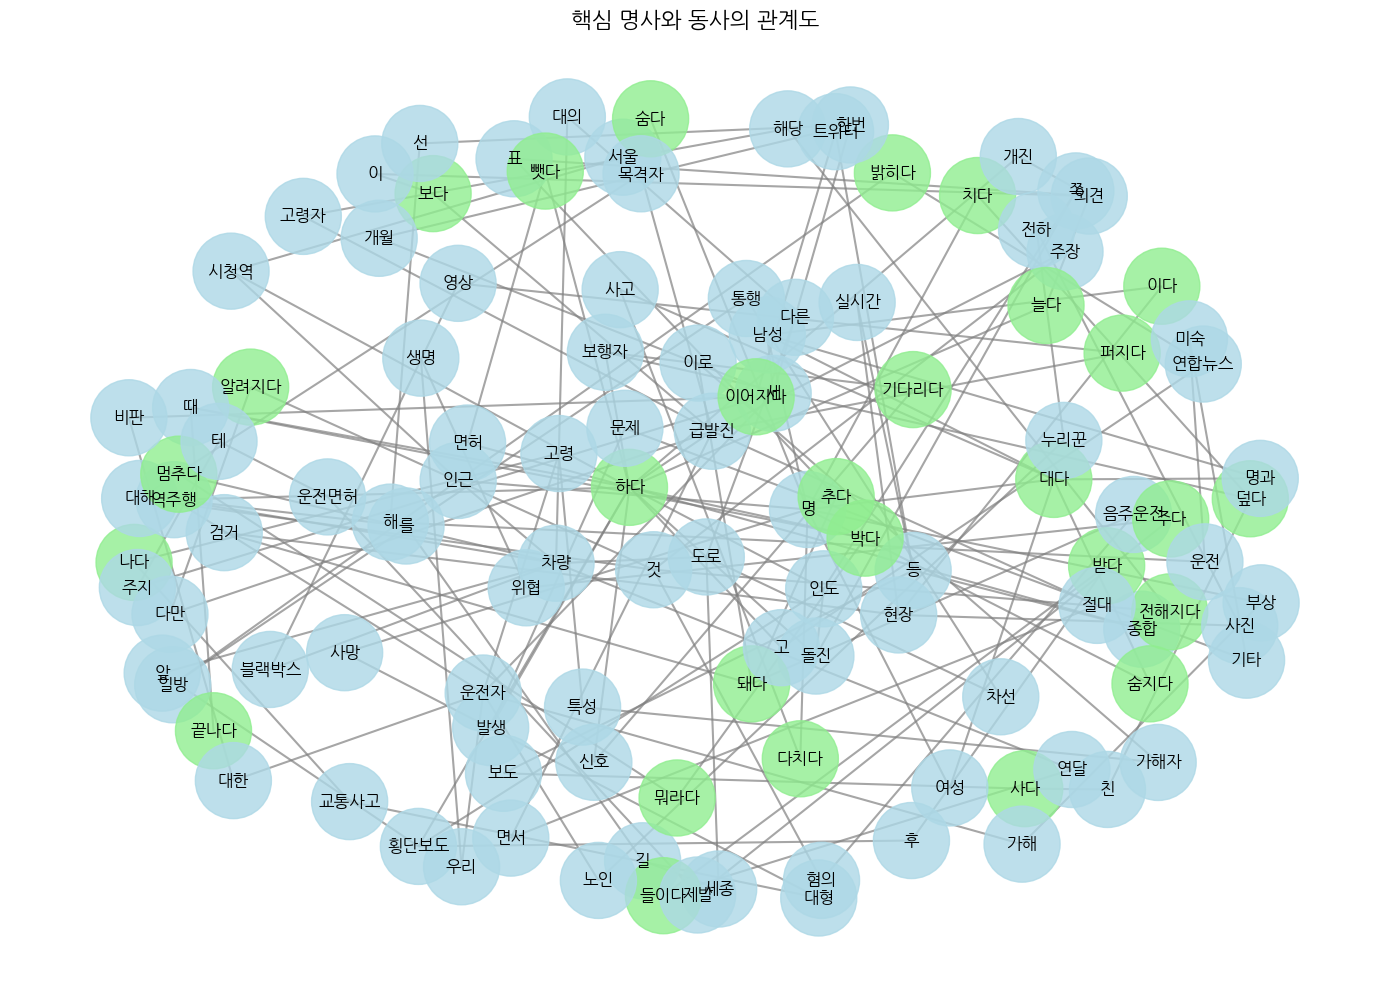

In [ ]:
create_relationship_graph4(df_doc['텍스트'][0])

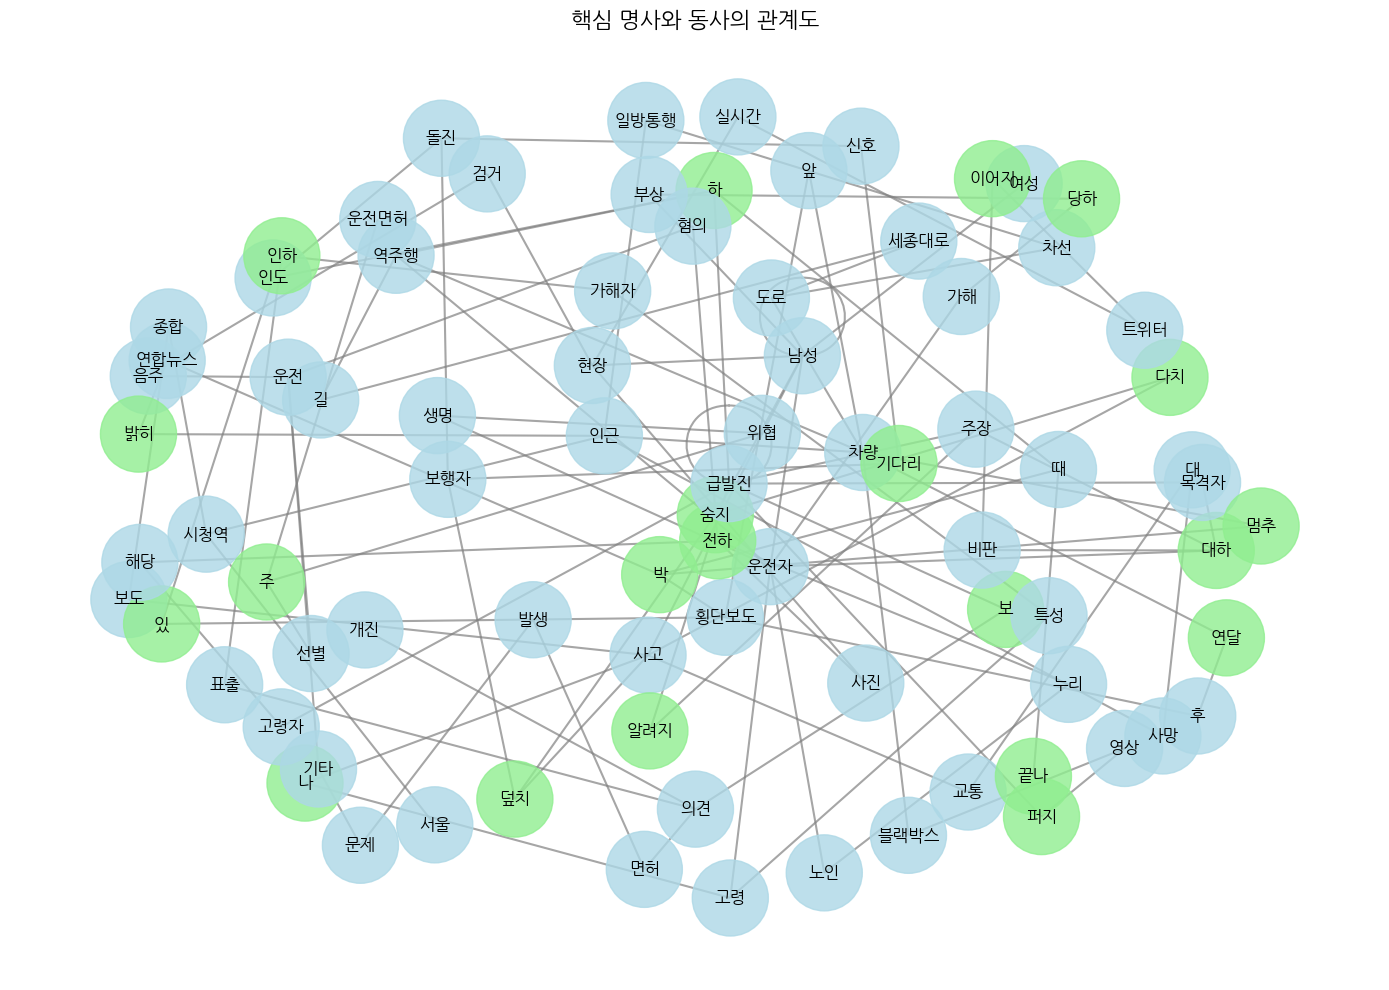

In [ ]:
create_relationship_graph3(df_doc['텍스트'][0])

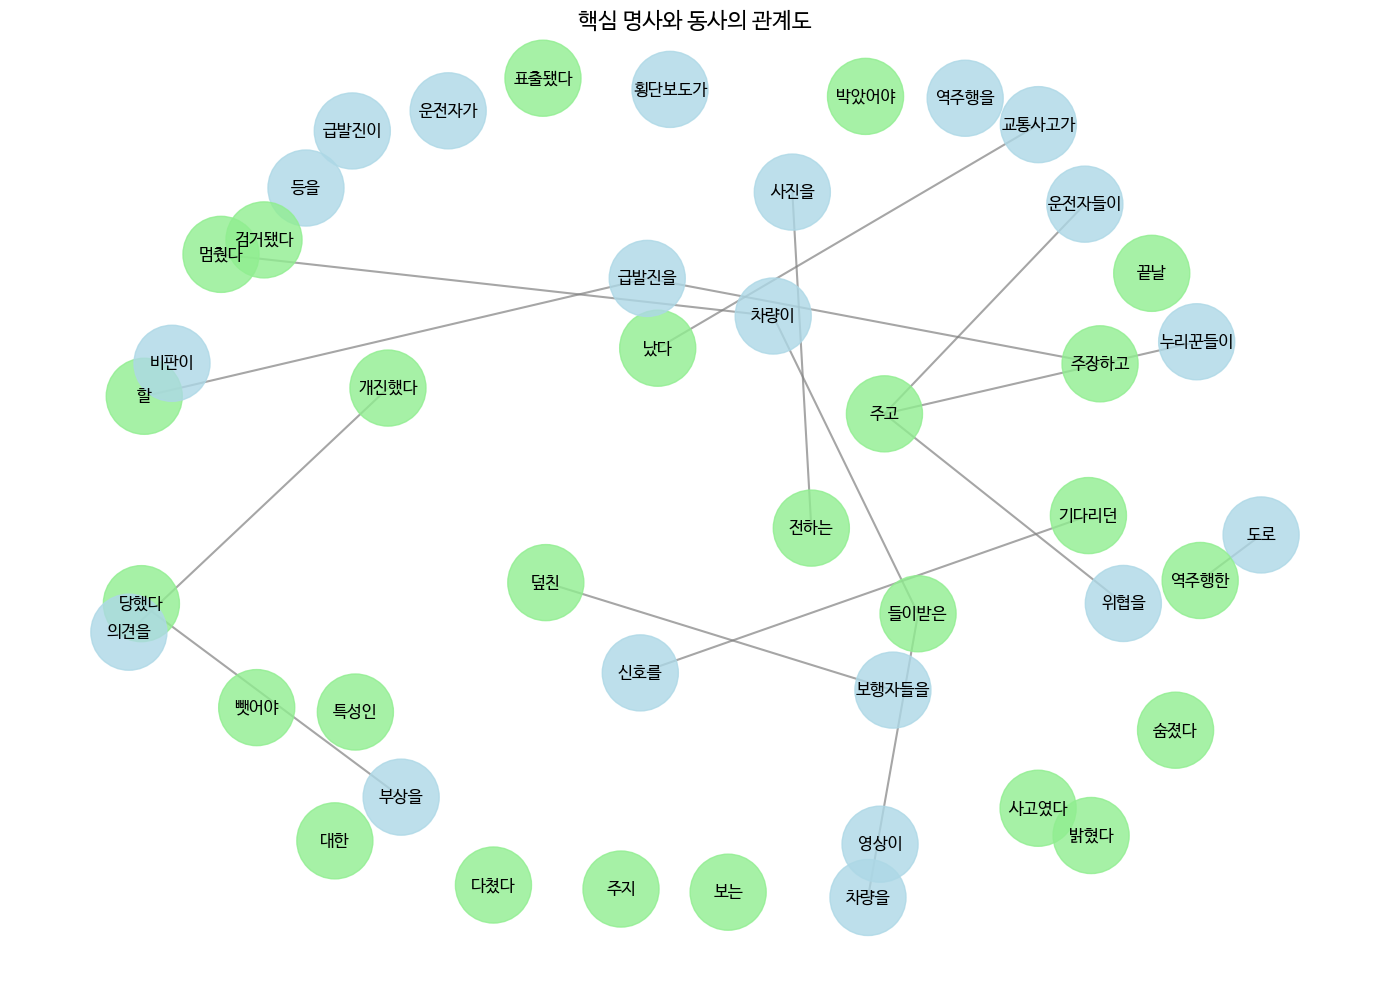

In [ ]:
create_relationship_graph2(df_doc['텍스트'][0])

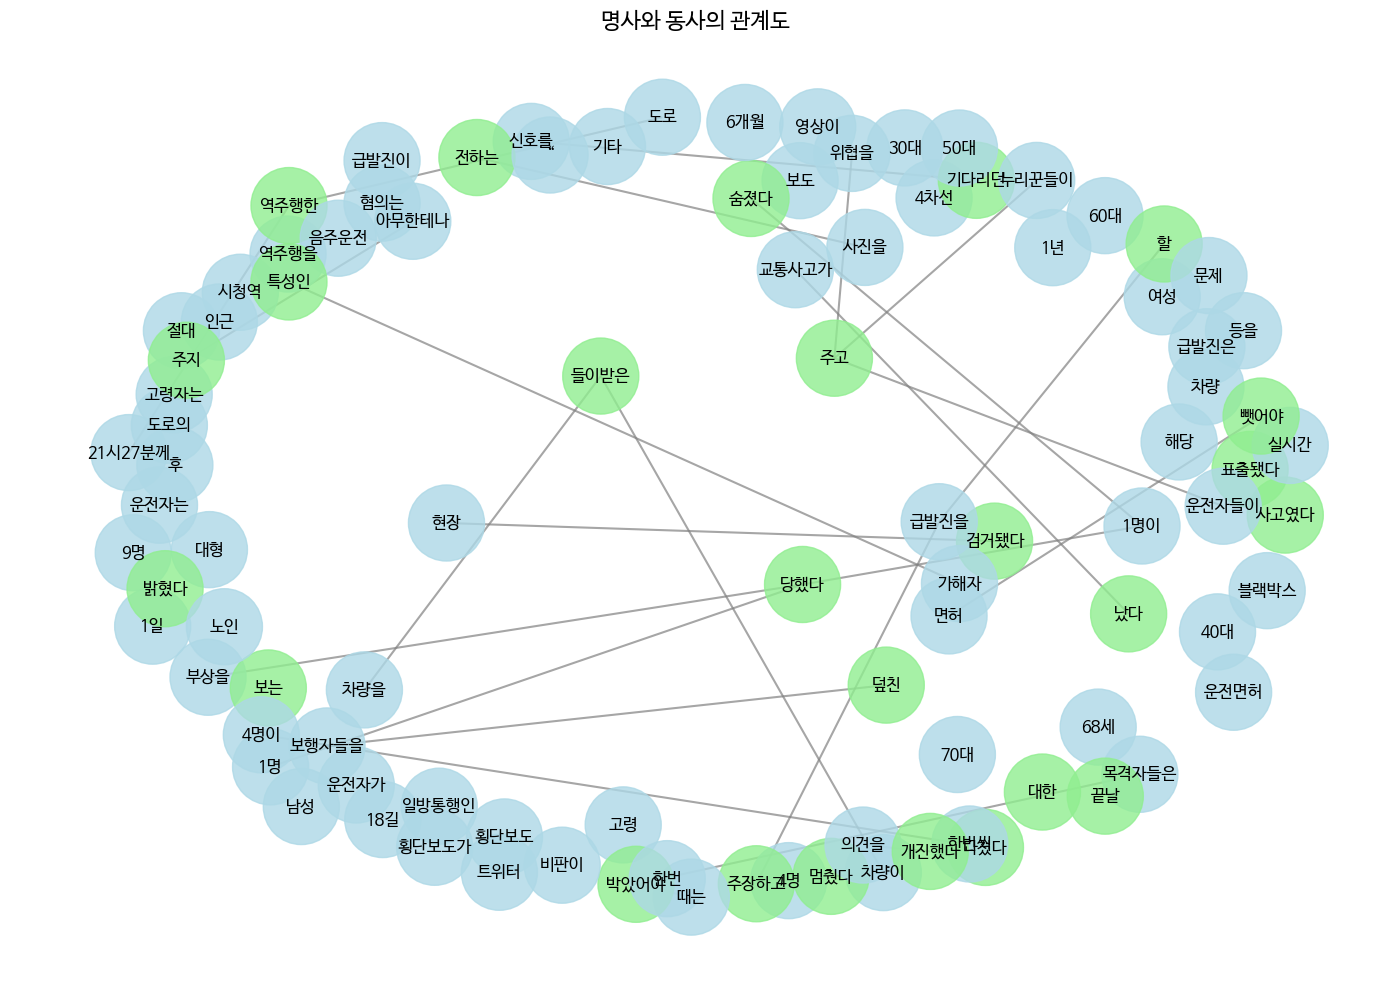

In [ ]:
create_relationship_graph(df_doc['텍스트'][0])

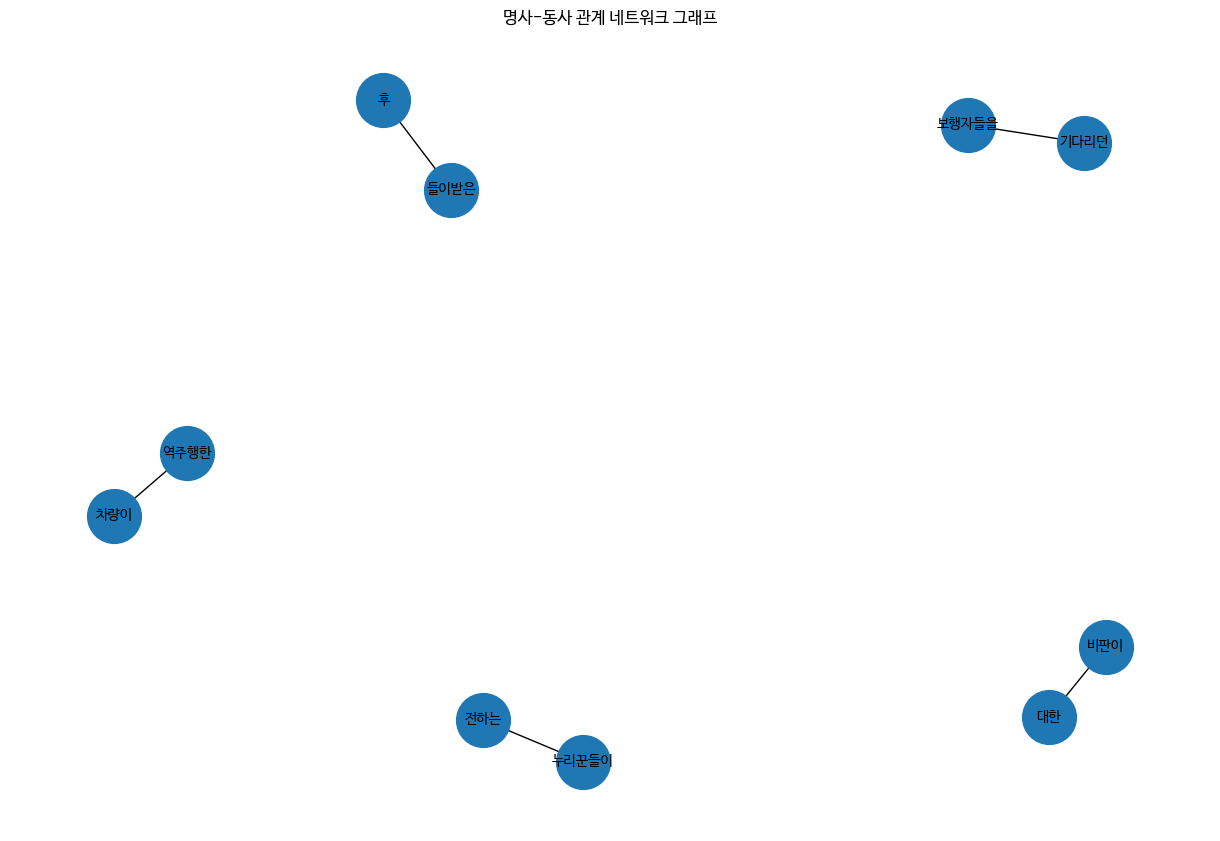

In [ ]:
analyze_word_relations(df_doc['텍스트'][0])